In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import math


In [20]:
# defining latice
L1 = [np.random.choice([1, -1]) for i in range (25)]
L1 = np.array(L1)
L1 = L1.reshape(5,5)
L1[L1 == 1] = 90
L1[L1 == -1] = 270

def Hamiltonian2D(J, L, x , y, h):
    n = np.shape(L)[0]
    Hamiltonian2D_H = -J * ((np.cos(L[x, y] - L[x, (y+1)%n])) + (np.cos(L[x, y] - L[x, (y-1)%n])) + (np.cos(L[x, y] - L[(x+1)%n, y])) + (np.cos(L[x, y] - L[(x-1)%n, y])))
    Hamiltonian2D_cos = h*np.cos(L[x,y]) 
    return np.array(Hamiltonian2D_H), np.array(Hamiltonian2D_cos)

# print(Hamiltonian2D(1, L1, 1, 1, 1))


In [3]:
# Hamiltonian array
# print(L1)

h = 1
x, y = np.indices(L1.shape)
L_hamiltonian = Hamiltonian2D(1,L1, x,y,h)
# print (L_hamiltonian)

In [4]:
# definfing Leapfrog and Artificial Hamiltonian

def P_dot_i_2D(J, h, phi, b, N ):
    P_dot_i_2D = -1*(phi/(2*b*J))+(N/2)*math.tanh((b*h)+phi)
    return np.array(P_dot_i_2D)


def leapfrog_2D(N_md, p_0, phi_0, J,h,b, N): 
    epsilon = 0.1/N_md
    p = p_0
    phi = phi_0
    phi += p*epsilon/2
    for i in range(N_md-1):
        p -= P_dot_i_2D(J,h,phi,b,N)*epsilon
        phi += p*epsilon
    
    p -=  P_dot_i_2D(J,h,phi,b,N)*epsilon
    phi += p*epsilon/2
    return p, phi


def Hamiltonian2D_art(p, phi, J, b, h, N):
    Hamiltonian2D_art = ((p**2)/2) + ((phi**2)/(4*b*J)) - N*np.log(2*np.cosh((b*h)+phi))
    return Hamiltonian2D_art

# print(leapfrog_2D(4, 0.1, 0.1, 1,1,1, 5))

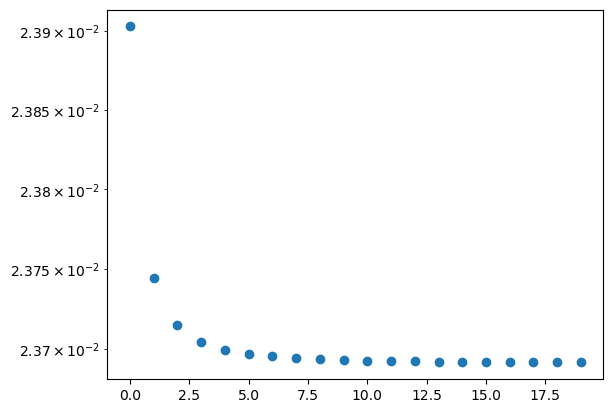

In [23]:
# Defining initial values
N_md = 20
N = 20
p_0 = 1
phi_0 = 1
J = 1/N       # J should be greater than 0
# N = 15        # N range is given between 5 to 20

# ________________________________________________________________________________

# for graphy plotting

diff = []
b = 1

# T = 300
# b=1/((1.380649 * (10**(-23)))*T)

for i in range(N_md):
    arr = leapfrog_2D(i+1, p_0, phi_0, J,h,b, N)
    p_f = arr[0]          # We need final values of p_f and phi_f to calculate H_f
    phi_f = arr[1]
    H_f = Hamiltonian2D_art(p_f, phi_f, J, b, h, N)
    H_0 = Hamiltonian2D_art(p_0, phi_0, J, b, h, N)
    
# The following is the quantity we want on y-axis
    diff.append(abs((H_f-H_0)/H_0)) 
    
plt.yscale('log')
plt.plot(diff, "o")

In [24]:
# Now we code the HMC algorithm

# Understanding: We sample from N space and integrate the EOM's using leapfrog to get p' and phi'
# Then we accept the value of phi' with the Metropolis accept/reject (with the given prob.) and repeat the process
# To keep in mind: We store every value of phi regardless to generate our Markov chain. If the algorithm rejects phi' we
# store phi

# So we need to accept and reject according to the probability distribution given in the sheet which is basically exp(H)

# Size of ensemble is given as N_cfg

def markov_chain(phi_i,N_cfg,N_md,J,N):
    chain = []
    chain.append(phi_i)
    for i in range(N_cfg):
        p = np.random.normal(0,1)  # Random sample
        new = leapfrog(N_md, p, chain[-1], J, beta, h, N) # Integrating leapfrog algorithm
        prob = np.exp(hamiltonian(p,chain[-1], J, beta, h, N)-hamiltonian(new[0], new[1], J, beta, h, N))
#  Given probability distribution function defined above
        if prob > np.random.uniform(0,1):   # Accept/reject
            chain.append(new[1])  
        else:                           
            chain.append(chain[-1]) 
    return chain